In [2]:
from textwrap import dedent
%matplotlib inline
import math
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import codecs
from datetime import datetime
from scipy.ndimage.filters import gaussian_filter

matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (15.0, 5.0)    # resize plots

def code_hider():
    """Make a button in the jupyter notebook to hide all code"""
    # Stolen from stackoverflow... forget which question
    # I would really like these buttons for every individual cell.. but I don't know how
    from IPython.display import HTML    # Please keep here, don't want hax to depend on ipython!
    return HTML(dedent('''
                       <script>
                       code_show=true
                       function code_toggle() {
                        if (code_show){
                        $('div.input').hide();
                          } else {
                        $('div.input').show();
                        }
                        code_show = !code_show
                       }
                       //$( document ).ready(code_toggle);
                       </script>
                       <form action="javascript:code_toggle()"><input type="submit"
                       value="Show/hide  all code in this notebook"></form>'''))

code_hider()


# Calibration du détecteur avec des sources radioactives

*authors*: Ioana. C. Maris, Louis Moureaux


Dans cette expérience vous allez apprendre à calibrer un détecteur. Vous devrez obtenir deux choses: l'échelle du détecteur et sa résolution. Le détecteur qu´on veut calibrer contient une chaîne de scintillateur, photomultiplicateur et acquisition de données.  Ces notes sont faites pour être une ligne directrice de ce labo: c'est à vous de trouver les réponses aux questions pendant le labo, en demandant aux personnes en charge ou en cherchant sur le web.

Pour faire la calibration, on va utiliser des sources radioactives.


<div class="alert alert-block alert-danger">
<b>Securité</b> 

Dans ce laboratoire, vous manipulerez des sources radioactives. Voici quelques règles élémentaires de sécurité:

<ul>
<li> Manipulez toujours les sources avec la pince prévue à cet effet;
<li> Ne laissez jamais les sources exposées à l'air libre et il faut les mettre derrière du plomb;
<li> Les sources ne peuvent sortir du labo;
<li> Lavez-vous les mains en sortant du labo.
</ul>

<p style="font-weight: bold"> Vous êtes responsables des sources; en particulier, vous les retrouverez vous-mêmes en cas de perte (dussiez-vous y passer la nuit). </p>
</div>




## Dispositif expérimental

**Détection des photons** Vous aurez à votre disposition au labo un scintillateur constitué d'un cristal scintillateur NaI, relié à un tube photomultiplicateur. Les scintillateurs sont des matériaux qui émettent de la lumière quand ils sont traversés par des particules ionisantes. Devant le scintillateur une plaque métallique est placée. Dans notre montage, cette lumière en arrivant sur la photocatode produit des électrons, qui sont ensuite multipliés. ([source de l'image](https://commons.wikimedia.org/wiki/File:Tubephotomultiplicateur.svg)):



![Schématique du tube PM](images/Photomultiplicateur.png)

Les tubes PM se basent sur une grande différence de potentiel appliquée entre des électrodes de forme spéciale (dynodes). Vous les étudierez plus en détail au [cours de physique des particules](http://www.iihe.ac.be/~lfavart/cours.html). Le signal produit est proportionnel à l'énergie des particules qui traversent le scintillateur.


<div class="alert alert-block alert-info">
<p><b>Q:</b>  Pourquoi on a besoin du scintillateur et comment est-ce qu'il fonctionne? </p>
<p><b>Q:</b>  Si le scintillateur mesure seulement des particules chargées, comment mesure-t´on les photons? </p>
<p><b>Q:</b>  Pourquoi y-a-t´il une plaque métallique devant le scintillateur? </p>
<p><b>Q:</b>  Quelle est le processus par lequel on peut extraire des électrons de la photocadode?</p>
<p><b>Q:</b>  Est-ce que vous pouvez donner des exemples ou on utilise des photomultiplicateurs? </p>
<p><b>Q:</b>  Quelle est la haute tension que l´on aplique sur le PM? Que cela change-t'il si on la modifie? </p>

</div>

<div class="alert alert-block alert-success">
<b> Tip: </b> Il y a beaucoup d´explications sur le web sur l'interprétation de spectres pris avec un scintillateur et un photomultiplicateur. Par example [ce lien](http://wanda.fiu.edu/teaching/courses/Modern_lab_manual/scintillator.html).
</div>


**Acquisition de données** 
Dans le montage utilisé au laboratoire, le courant sortant du photomultiplicateur est amplifié, transformé en un signal numérique par un ADC (convertisseur analogique-digital), qui est enfin lu par un ordinateur. L'ADC a plusieurs intervals pour numeriser le signal analogique. Vous avez à votre disposition aussi un scaler pour mesurer le taux et un oscilloscope.

<div class="alert alert-block alert-info">
<p><b>Q:</b>  Est-ce que l'amplificateur a une autre fonction que d´amplifier l'amplitude du signal? </p>
<p><b>Q:</b>  Quelle est l'amplification que vous utilisez dans cette experience? </p>
<p><b>Q:</b>  Comment transfère-t´on les données de l´ADC vers l'ordinateur? </p>
<p><b>Q:</b>  Quelle est la difference entre les mesures du bruit de fond avec Geiger et cette expérience? </p>
</div>

<div class="alert alert-block alert-success">
<p><b>Tip:</b> Prenez plusieurs données avec 2-3 valeurs de numérisations pour l´ADC</p>
<p><b>Tip:</b> Regardez sur l'oscilloscope la forme du signal </p>
<p><b>Tip:</b> Comparez le nombre d´évènements pris dans l'expérience Geiger avec le scaler </p>
</div>


![DAQ](images/daq.jpg)



** Sources comme calibration ** Pour calibrer le detecteur, on utilise des sources radioactives. Vous avez à votre disposition plusieurs sources: ${}^{137}\mathrm{Cs}$, ${}^{133}\mathrm{Ba}$, ${}^{60}\mathrm{Co}$, ${}^{22}\mathrm{Na}$, ${}^{247}\mathrm{Am}$, ${}^{152}\mathrm{Eu}$. Dans la partie théorique de ce document vous trouverez quelques propriétés des sources.
Cinq types de désintégrations existent:

1. $\alpha$ par le processus:  ${}_Z^AX\to {}_{Z-2}^{A-2}Y\,\mathrm{He}$
1. $\gamma$ par le processus: $X^*\to X\,\gamma$
1. $\beta^+$ par le processus: ${}^A_ZX \to {}^{A+1}_{Z-1}Y \,e^+\, \nu_e$ 
1. $\beta^-$ par le processus: ${}^A_ZX \to {}^{A-1}_{Z+1}Y \,e^-\, \bar\nu_e$
1. Éjection d'un neutron: ${}^AX\to {}^{A-1}X\,n$


<div class="alert alert-block alert-info">
<p><b>Q:</b>  Parmi les sources que vous utilisez, lesquelles trouve-t-on dans la nature? </p>
<p><b>Q:</b>  Pouvez vous indentifier les désintégrations pour les quelques sources énumérées? </p>
</div>

<div class="alert alert-block alert-success">
<p><b>Tip:</b>  Trouvez les sources dans la <q>bible</q> du nucléaire </p>
</div>

** Analyse de données** Les données vont être stockées dans l'ordinateur du labo. La plus grande partie de ce labo consiste à analyser les données.

<div class="alert alert-block alert-success">
<p><b>Tip:</b>  Amenez votre ordinateur avec vous si vous voulez commencer l'analyse dans le labo (fortement conseillé)  </p>
<p><b>Tip:</b>  Utilisez le modèle de notebook Jupyter. Vous le trouverez sur l'Université Virtuelle</p>

</div>


##  Manipulation à effectuer

1. Prenez le spectre des differentes sources. Les sources indispensables sont ${}^{137}\mathrm{Cs}$ et ${}^{152}\mathrm{Eu}$. Vous avez le choix de prendre le spectre des autres sources
1. Prenez le spectre du bruit
1. Prenez le spectre d'une source inconnue
1. Comparez le bruit de fond  mesuré en utilisant les scalers avec les résultats que vous avez obtenus dans le cas du compteur Geiger.


<div class="alert alert-block alert-success">
<p><b>Tip:</b>  L'accumulation d'une quantité suffisante d'évènements du bruit de fond prend du temps, commencez par utiliser les sources. </p>
</div>



## Analyse et interprètation des données 


1. Sélectionnez les pics dans vos mesures et ajustez une fonction gaussienne pour obtenir la moyenne et la largeur des pics.

1. Calibrez le détecteur en trouvant la relation linéaire entre l'énergie du photon incident et l'unité arbitraire du système numérique. Interprétez les paramètres obtenus. 

1. Déterminez la résolution (absolue et relative) du détecteur en fonction de l'énergie et essayez d´en comprendre le comportement. 

1. En utilisant la courbe de calibration que vous avez obtenue et le temps de mesure, transformez le spectre pris en unitées arbitraires en fréquence versus énergie.

1. Déduisez-en l'énergie des pics non utilisés dans la calibration et aussi présents dans la source inconnue (utilisez un ajustement), et comparez ces résultats à la littérature.

1. En plus des pics de désintégration, les spectres comportent des contributions dues à la diffusion Compton des photons incidents. Identifiez-les et interprètez-les dans le spectre du ${}^{137}\mathrm{Cs}$.

<div class="alert alert-block alert-success">
<b>Tip:</b>  Vous pouvez gagner des points supplémentaires en faisant des analyses originales.
</div>





Si vous désirez étendre votre analyse, voici quelques idées:

- Vous disposez de cinq mesures du pic du plomb (une pour chaque spectre). Peut-on les considérer comme indépendantes ?  Comparez les mesures et interprétez les résultats.
- Trouvez si le comportement de l'ADC est linéaire en faisant des mesures avec différentes échelles 
- Utilisez le bruit de fond de manière originale
- Réalisez un ajustement unique pour les trois pics du ${}^{133}\mathrm{Ba}$ qui se superposent
- Mesurez l'âge d'une des sources
- Déduisez l'efficacité du detecteur
- Est-ce qu'on pourrait voir les photons émis par ces sources avec les yeux? Argumentez et produisez un graphique pour l'expliquer. 

<div class="alert alert-block alert-success">
<b>Tip:</b> Si vous essayez, que ça ne fonctionne pas et que vous pouvez expliquer ce qui rend la mesure impossible, c'est un bon point à inclure dans votre rapport. En plus profitez de la présence des persones dans le labo pour vous donner plus de conseils.
</div>
 

### Sources étudiées

Le tableau ci-dessous reprend quelques propriétés des sources que vous étudierez au laboratoire.

<table>
    <tr><th>Mode de désintégration</th><th style="text-align: left">$E_\gamma$</th></tr>
    <tr><td style="text-align: left">${}^{137}\mathrm{Cs}\to\mathrm{Ba}\,e^-\bar\nu_e\,\gamma$</td><td style="text-align: left">$661\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{133}\mathrm{Ba}\to\mathrm{Cs}\,\gamma$</td><td style="text-align: left">$288\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{60}\mathrm{Co}\to\mathrm{Ni}\,e^-\bar\nu_e\,\gamma\gamma$</td><td style="text-align: left">$1173$ et $1332\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{22}\mathrm{Na}\to\mathrm{Ne}\,e^+\nu_e\,\gamma$</td><td style="text-align: left">$1274\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{22}\mathrm{Na}\to\mathrm{Ne}\,e^+\nu_e\,\gamma$</td><td style="text-align: left">$511\text{ keV}$ (masse de l'électron)</td></tr>
</table>

## Éléments théoriques

Dans cette manipulation, nous allons étudier les particules produites lors des désintégrations, et en particulier les photons.


Comme vous avez déjà eu l'occasion de l'observer dans l'experiement Geiger, la désintégration d'un noyau est un phénomène aléatoire. Cependant, certaines des propriétés de ce processus sont au contraire constantes: c'est notamment le cas de l'énergie du photon dans une désintégration $\gamma$ ($X^*\to X\,\gamma$). Celle-ci peut être prédite par un calcul simple: dans l'approximation où l'impulsion du noyau $X$ est négligeable, on obtient:

$$ E_\gamma = m_{X} - m_{X^*}, $$


L'énergie typique produite lors d'une désintégration  de l'ordre de 100 keV (kiloélectronvolt). Par comparaison, l'énergie nécessaire pour ioniser un atome d'hydrogène est de 13,6 eV. 


** Canaux de désintégration et spectre en énergie **
Un même noyau peut souvent se désintégrer de plusieurs façons différentes, qu'on appelle *canaux*. À chaque canal est associé une probabilité, le *rapport de branchement*. La somme de tous les rapports de branchements est égale à 1. Si l'on se concentre sur la probabilité d'émettre des particules d'énergie donnée (on parle de leur *spectre en énergie*)  et qu'on la porte en graphique, on obtient des pics aux valeurs correspondant aux différences de masses:

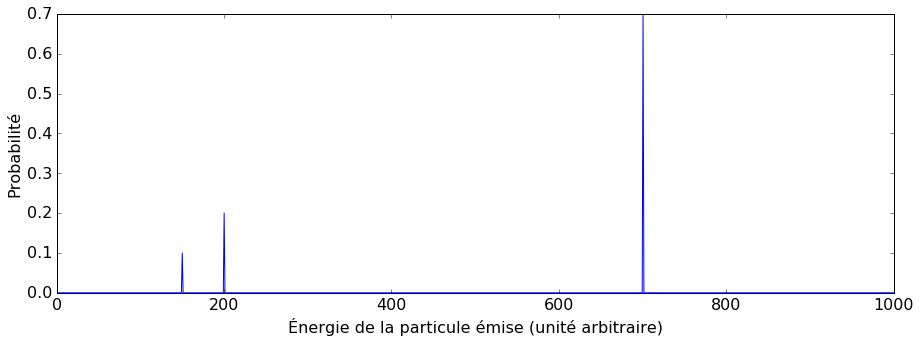

In [3]:
energie = np.linspace(0, 1000, 1000)
spectre = np.zeros(1000)
spectre[700] = 0.7
spectre[200] = 0.2
spectre[150] = 0.1
plt.plot(energie, spectre)
plt.xlabel("Énergie de la particule émise (unité arbitraire)")
plt.ylabel("Probabilité")

Dans l'exemple ci-dessus, on a trois canaux de désintégration avec des probabilités de 70%, 20% et 10%, correspondant chacun à un pic. Dans la réalité, un noyau peut posséder plusieurs dizaines de canaux de désintégration; ceux-ci (ainsi que les rapports de branchement associés) sont répertoriés dans des ouvrages de référence.

** Chaînes de désintégration ** Il arrive souvent qu'un noyau se désintègre vers un état instable d'un autre noyau. Ce dernier se désintègre alors à son tour, ajoutant des lignes au spectre du premier. C'est ainsi qu'on observe des photons dans les produits de désintégration du cobalt 60. La première désintégration est une $\beta^-$:

$$ {}^{60}\mathrm{Co} \to \mathrm{Ni}^{**} e^- \bar\nu_e$$

Le noyau de nickel excité ($\mathrm{Ni}^{**}$) se désexcite ensuite en deux étapes, émettant à chaque fois un photon:

$$ \mathrm{Ni}^{**} \to \mathrm{Ni}^* \gamma \to \mathrm{Ni} \,\gamma\gamma $$

Ces deux dernières réactions ayant lieu en un temps très court (de l'ordre de la picoseconde), les pics correspondants sont souvent inclus dans le spectre du cobalt 60. Si on reprend notre exemple et qu'on suppose que le canal à 70% mêne à un noyau qui peut se désexciter de deux façons différentes, on obtient:

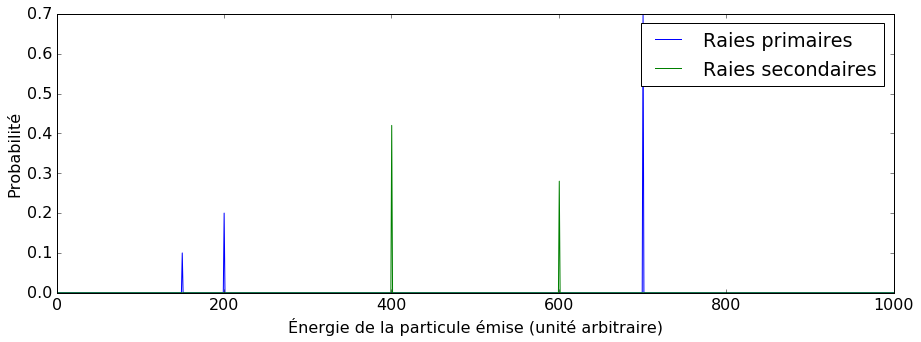

In [4]:
energie = np.linspace(0, 1000, 1000)
spectre = np.zeros(1000)
spectre[700] = 0.7
spectre[200] = 0.2
spectre[150] = 0.1
plt.plot(energie, spectre)
spectre = np.zeros(1000)
spectre[600] = 0.7*0.4
spectre[400] = 0.7*0.6
plt.plot(energie, spectre)
plt.legend(("Raies primaires", "Raies secondaires"))
plt.xlabel("Énergie de la particule émise (unité arbitraire)")
plt.ylabel("Probabilité")

### Effets expérimentaux

Différents effets expérimentaux affectent la distribution mesurée, et leur compréhension est importante pour l'interprétation physique des données qu'on mesure.

**Résolution du détecteur**
Il n'existe pas de détecteurs parfaits créés par l'Homme. Il est trés important de connaître les comportements des détecteurs et de les  quantifier en mesurant leur résolution.

On mesure les pics très marqués dans le spectre théorique comme des courbes plus larges:

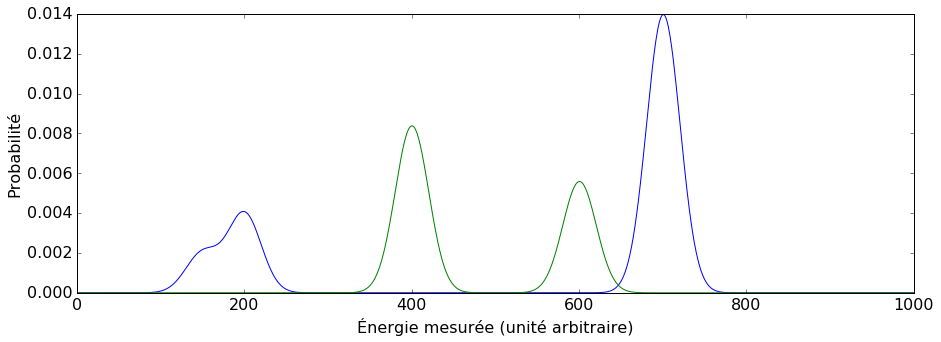

In [5]:
energie = np.linspace(0, 1000, 1000)
spectre1 = np.zeros(1000)
spectre1[700] = 0.7
spectre1[200] = 0.2
spectre1[150] = 0.1
plt.plot(energie, gaussian_filter(spectre1, 20))
spectre2 = np.zeros(1000)
spectre2[600] = 0.7*0.4
spectre2[400] = 0.7*0.6
plt.plot(energie, gaussian_filter(spectre2, 20))
plt.xlabel("Énergie mesurée (unité arbitraire)")
plt.ylabel("Probabilité")

La largeur des pics est données par la *résolution en énergie* du système, $\Delta E_\gamma$. 

Normalment la résolution en énergie d'un appareil n'est pas constante et l'évolution de la résolution avec l'énergie est une des mesures les plus importantes pour la characterisation des détecteurs. La résolution que l'on mesure est la résolution de tout le système comprenant aussi l'électronique.

<div class="alert alert-block alert-info">
<b>Q:</b> Quelle est la résolution nécessaire pour pouvoir séparer deux pics?
</div>

<div class="alert alert-block alert-success">
<b>Tip:</b> Pour une meilleure compréhension: utilisez le code de ce notebook Jupyter et modifiez la résolution du détecteur
</div>

** Bruit de fond **

Un deuxième effet expérimental important est la présence de bruit de fond, causé par deux facteurs principaux:

- **L'environnement**: Notre système n'étant pas totalement isolé du reste du monde, il détectera aussi des particules ne provenant pas de la source. En particulier, le coffrage de plomb qui l'entoure est devenu radioactif suite à une exposition prolongée aux sources. La seule présence dans la pièce d'une personne ayant subi un examen de radiologie peut empêcher le système de fonctionner correctement; activer le WiFi sur un ordinateur modifie également le bruit.

- **L'électronique**: Les composantes électroniques du système d'acquisition utilisé  produisent des fluctuations du signal et même s'il n'y a pas de photons, on peut indentifier ces fluctuations comme des signaux de très basse énergie.  On s'en prémunit autant que possible en utilisant un seuil (comme pour le trigger de l'oscilloscope).

La combinaison des différents bruits de fond s'ajoute aux pics dûs à la source que l'on souhaite mesurer, avec une contribution qui décroît typiquement avec l'énergie mesurée:

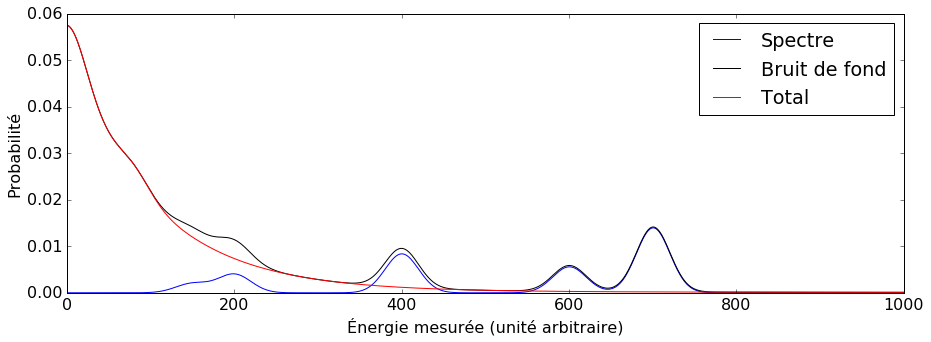

In [13]:
energie = np.linspace(0, 1000, 1000)
spectre = np.zeros(1000)
spectre[700] = 0.7
spectre[200] = 0.2
spectre[150] = 0.1
spectre[600] = 0.7*0.4
spectre[400] = 0.7*0.6
plt.plot(energie, gaussian_filter(spectre, 20), color='blue')
bruit = np.zeros(1000)
bruit = np.exp(-energie / 100 - 3) + 0.1 / (energie + 1)
bruit[80] = 0.2
plt.plot(energie, gaussian_filter(spectre + bruit, 20), color='black')
plt.plot(energie, gaussian_filter(bruit, 20), color='red')
plt.legend(('Spectre', 'Bruit de fond', 'Total'))
plt.xlabel("Énergie mesurée (unité arbitraire)")
plt.ylabel("Probabilité")

Heureusement, le spectre du bruit de fond peut être mesuré facilement, en prenant des données quand aucune source n'est présente. Il est alors possible de soustraire sa contribution des données mesurées avec une source.

## Diffusion Compton

Un dernier effet important est l'interaction des photons incidents avec la matière. La scintillation est produite seulement par des particules chargées (ionisantes), alors le signal qu'on mesure est produit par des photons de scintillation provenant d'électrons. Lors de  leur interaction avec la matière les photons peuvent transférer de l'énergie aux électrons ou ils peuvent produire des électrons. Dans l'image prise  [d'ici](http://wanda.fiu.edu/teaching/courses/Modern_lab_manual/scintillator.html) on voit la section efficace pour les photons dans les différents matériaux.

![La section efficace des photons](images/sigma_gamma.png)


<div class="alert alert-block alert-success">
<b>Tip:</b> Aprenez en cherchant sur le web ou dans un livre ce que signifie chacun de ces processus. 
</div>
 

En particulier, les photons émis par les sources peuvent entrer en collision avec les électrons du milieu. Lors de ces collisons, le photon vas perdre de l'énergie. La diffusion Compton est descrite par cette formule:

$$ \frac{1}{E_{f}} - \frac{1}{E_{i}} = \frac{1}{m_e c^2} (1- \cos \theta ) $$

avec $E_{f}$ l'énergie du photon final, $E_{i}$ l'énergie du photon initial et $\theta$ l'angle de déviation du photon. 

L'énergie $E_{f}$ du photon diffusé est comprise entre les bornes suivantes:

$$ \frac{m_e}{m_e+2E_i} \le \frac{E_f}{E_i} \le 1, $$

où $m_e = 511\,\mathrm{keV}/c^2$ est la masse de l'électron et $E_\gamma$ est l'énergie du photon incident. 


Un calcul plus perfectionné permet de trouver la forme de la contribution au spectre (notez que, pour obtenir le graphe ci-dessous, certains paramètres ont été définis arbitrairement):


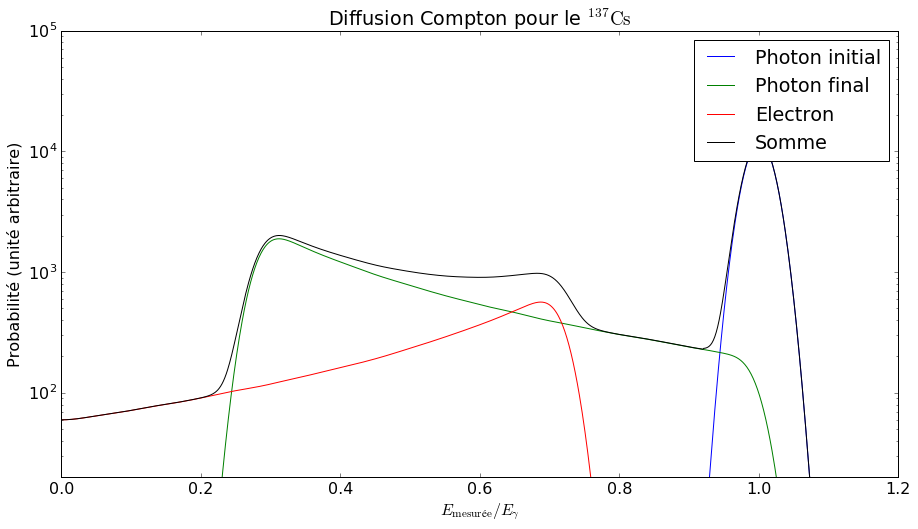

In [15]:
E = 661
bins = np.linspace(0, 1.2, 1200)
N = int(1e6)

prop = np.random.rand(N)

plt.figure(figsize = (15.0, 8.0))

peak = bins.copy()[:-1]
peak[1000] = 0.6 * N
plt.semilogy(bins[:-1], gaussian_filter(peak, sigma=20))

costheta = 1 - 2*np.random.rand(N)

egamma = 511/(511+E*(1-costheta))

egammaCount, egammaEdges = np.histogram(egamma, bins=bins, weights=prop)
plt.semilogy(bins[:-1], gaussian_filter(egammaCount, sigma=20))

costheta = 1 - 2*np.random.rand(N)
ee = 1 - 511/(511+E*(1-costheta))
eeCount, eeEdges = np.histogram(ee, bins=bins, weights=1-prop)
eeCount *= 0.3
plt.semilogy(bins[:-1], gaussian_filter(eeCount, sigma=20))

total = egammaCount + eeCount + peak
plt.semilogy(bins[:-1], gaussian_filter(total, sigma=20), color='black')

plt.title('Diffusion Compton pour le ${}^{137}\mathrm{Cs}$')
plt.xlabel('$E_\mathrm{mesurée}/E_\gamma$')
plt.ylabel('Probabilité (unité arbitraire)')
plt.ylim((20, 1e5))
plt.legend(('Photon initial', 'Photon final', 'Electron', 'Somme'))

Un "plateau Compton" étant associé à chaque pic du spectre. 

1. Le photon intial a donné toute son énergie à un électron par d'autres processus
1. On mesure l'énergie du photon final qui a passé l'énergie à un électron.
1. On mesure l'énergie qui a été transmise à l'électron par le processus Compton.

<div class="alert alert-block alert-success">
<p><b>Tip:</b> En modifiant le code du jupyter notebook essayez de voir ce qui se passe avec le plateau et le *Compton edge* pour différentes énergies et résolutions. </p>

<p><b>Tip:</b> Dans les objects astrophysiques on trouve un autre procesus: Compton inverse. Pour mieux comprendre l'importance du Compton dans l'Univers essayez de trouver plus d'info sur internet. </p>

</div>

<div class="alert alert-block alert-info">
<b>Q:</b> Quelle est l'énergie maximale qu'on peut transmettre à l'électron par l'effet Compton? 
</div>




## Le raport
<div class="alert alert-block alert-success">
<p><b>Tip:</b> Decrivez en détails le detecteur que vous avez utilisé. </p>
<p><b>Tip:</b> Faites attention aux incertitudes. </p>
<p><b>Tip:</b> Utilisez les informations acquises dans le laboratoire et n'oubliez pas de prendre des notes. </p>
<p><b>Tip:</b> L'originalité et la compréhension de l'expérience donnent des points suplimentaire! </p>
</div>
